# TP3 - Adversarial Attack

## Binôme Stéphanie ROUXEL / Hy-Boui CHANG Executive Master IASD 2019/2020



In [ ]:
# [CELL ID] 1

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

[CELL ID] 2
## From adversarial examples to training robust models

In the previous notebooks, we focused on methods for solving the maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this notebook, we will focus on training a robust classifier. More precisly, we aim at solving following minimization problem, namely Adversarial Training:
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$, and that they get to specialize their attack to whatever parameters we have chosen in the outer minimization. The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary but it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

## Exercice 1
1. Train a robust classifier using Adversarial Training
2. Evaluate your classifier on natural and adversarial examples
3. Make an analysis and conclude

In [ ]:
# [CELL ID] 3

# load MNIST dataset
def load_mnist(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.MNIST("./data", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

batch_size = 100
train_loader = load_mnist('train', batch_size)
test_loader = load_mnist('test', batch_size)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# [CELL ID] 4

class FastGradientSignMethod():
  
    def __init__(self, model, eps):
        self.model=model
        self.eps=eps
  
    def compute(self, x, y):
        x,y = x.to(device), y.to(device)
        delta = torch.zeros_like(x, requires_grad=True)
        loss = nn.CrossEntropyLoss()(self.model(x + delta), y) 
        loss.backward()
        return self.eps * delta.grad.detach().sign() 

In [ ]:
eps=0.1
# on créé les instances de la classe

fgsm = FastGradientSignMethod(conv_model, eps)
fgsm_fgsm = FastGradientSignMethod(conv_model_fgsm, eps)
pgd_fgsm = FastGradientSignMethod(conv_model_pgd, eps)

In [ ]:
class ProjectedGradientDescent():
  
  def __init__(self, model, eps, alpha, num_iter):
    self.model=model
    self.eps=eps
    self.alpha=alpha
    self.num_iter=num_iter
  
  def compute(self, x, y):
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(self.model(x + delta), y) 
        loss.backward() 
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-eps,eps)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
eps=0.1
alpha=10000
num_iter=100

pgd = ProjectedGradientDescent(conv_model, eps, alpha, num_iter)
fgsm_pgd = ProjectedGradientDescent(conv_model_fgsm, eps, alpha, num_iter)
pgd_pgd = ProjectedGradientDescent(conv_model_pgd, eps, alpha, num_iter)

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [ ]:
class ConvModel(torch.nn.Module):
  
    def __init__(self):

        super(ConvModel, self).__init__()

        self.layers = nn.Sequential(
        
        nn.Conv2d(1, 32, 3, padding=1),
        nn.MaxPool2d(2,2), # kernel size, stride, padding
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, padding = 1, stride = 2),
        nn.MaxPool2d(2,2), # kernel size, stride, padding
        nn.ReLU(),

        Flatten(),

        nn.Linear(32*9,200),
        nn.ReLU(),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )


    def forward(self, x):
        x=self.layers(x)
        
        return x

In [ ]:
# [CELL ID] 6

def adversarial_train_model(model, criterion, optimizer, loader,attack=None):

  epochs =10
    
  for epoch in range(epochs):

    total_loss, total_err, total_acc = 0.,0.,0.

    for X,y in loader:
          X,y = X.to(device), y.to(device)
          if attack !=None:
            delta=attack.compute(X,y)

          else:
            delta=0
          yp = model(X+delta)
          loss = criterion(yp, y)           
         
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          total_err += (yp.max(dim=1)[1] != y).sum().item()
          total_acc += (yp.max(dim=1)[1] == y).sum().item()
          total_loss += loss.item() * X.shape[0]

    print('epoch {}, nb errors {}, dataset size {}, error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(epoch, total_err, len(loader.dataset), total_err/len(loader.dataset), total_acc/len(loader.dataset), total_loss/len(loader.dataset) ))



In [ ]:
conv_model = ConvModel().to(device) 
conv_model_fgsm = ConvModel().to(device) 
conv_model_pgd = ConvModel().to(device) 
# define your loss function
criterion = torch.nn.CrossEntropyLoss()

# define your optimizer
opt = optim.SGD(conv_model.parameters(), lr=1e-1)
opt_fgsm = optim.SGD(conv_model_fgsm.parameters(), lr=1e-1)
opt_pgd = optim.SGD(conv_model_pgd.parameters(), lr=1e-1)

In [ ]:
adversarial_train_model(conv_model, criterion, opt, train_loader)  #entrainement sans attack (idem notebook 2)

epoch 0, nb errors 18545.0, dataset size 60000, error: 0.309, accuracy : 0.691, loss 0.9168
epoch 1, nb errors 2902.0, dataset size 60000, error: 0.048, accuracy : 0.952, loss 0.1495
epoch 2, nb errors 1852.0, dataset size 60000, error: 0.031, accuracy : 0.969, loss 0.0980
epoch 3, nb errors 1439.0, dataset size 60000, error: 0.024, accuracy : 0.976, loss 0.0759
epoch 4, nb errors 1151.0, dataset size 60000, error: 0.019, accuracy : 0.981, loss 0.0612
epoch 5, nb errors 956.0, dataset size 60000, error: 0.016, accuracy : 0.984, loss 0.0510
epoch 6, nb errors 834.0, dataset size 60000, error: 0.014, accuracy : 0.986, loss 0.0440
epoch 7, nb errors 719.0, dataset size 60000, error: 0.012, accuracy : 0.988, loss 0.0382
epoch 8, nb errors 618.0, dataset size 60000, error: 0.010, accuracy : 0.990, loss 0.0334
epoch 9, nb errors 561.0, dataset size 60000, error: 0.009, accuracy : 0.991, loss 0.0295


In [ ]:
adversarial_train_model(conv_model_fgsm, criterion, opt_fgsm, train_loader, fgsm_fgsm)  #entrainement avec attack fgsm

epoch 0, nb errors 13736.0, dataset size 60000, error: 0.229, accuracy : 0.771, loss 0.6617
epoch 1, nb errors 8140.0, dataset size 60000, error: 0.136, accuracy : 0.864, loss 0.3984
epoch 2, nb errors 6411.0, dataset size 60000, error: 0.107, accuracy : 0.893, loss 0.3186
epoch 3, nb errors 5464.0, dataset size 60000, error: 0.091, accuracy : 0.909, loss 0.2715
epoch 4, nb errors 4850.0, dataset size 60000, error: 0.081, accuracy : 0.919, loss 0.2407
epoch 5, nb errors 4310.0, dataset size 60000, error: 0.072, accuracy : 0.928, loss 0.2168
epoch 6, nb errors 3963.0, dataset size 60000, error: 0.066, accuracy : 0.934, loss 0.1983
epoch 7, nb errors 3708.0, dataset size 60000, error: 0.062, accuracy : 0.938, loss 0.1830
epoch 8, nb errors 3404.0, dataset size 60000, error: 0.057, accuracy : 0.943, loss 0.1686
epoch 9, nb errors 3171.0, dataset size 60000, error: 0.053, accuracy : 0.947, loss 0.1587


In [ ]:
adversarial_train_model(conv_model_pgd, criterion, opt_pgd, train_loader, pgd_pgd)  #entrainement avec attack pgd

epoch 0, nb errors 43689.0, dataset size 60000, error: 0.728, accuracy : 0.272, loss 1.9946
epoch 1, nb errors 15217.0, dataset size 60000, error: 0.254, accuracy : 0.746, loss 0.7131
epoch 2, nb errors 9130.0, dataset size 60000, error: 0.152, accuracy : 0.848, loss 0.4390
epoch 3, nb errors 6859.0, dataset size 60000, error: 0.114, accuracy : 0.886, loss 0.3332
epoch 4, nb errors 5567.0, dataset size 60000, error: 0.093, accuracy : 0.907, loss 0.2712
epoch 5, nb errors 4734.0, dataset size 60000, error: 0.079, accuracy : 0.921, loss 0.2307
epoch 6, nb errors 4137.0, dataset size 60000, error: 0.069, accuracy : 0.931, loss 0.2041
epoch 7, nb errors 3702.0, dataset size 60000, error: 0.062, accuracy : 0.938, loss 0.1837
epoch 8, nb errors 3446.0, dataset size 60000, error: 0.057, accuracy : 0.943, loss 0.1705
epoch 9, nb errors 3217.0, dataset size 60000, error: 0.054, accuracy : 0.946, loss 0.1589


In [ ]:
with torch.no_grad():

  def eval_model(model, loader, attack=None):

    total_loss, total_err, total_acc = 0., 0., 0.
    delta = 0.
      
    for X,y in loader:
          
      X,y = X.to(device), y.to(device)

      if attack != None :
        delta=attack.compute(X,y).to(device)

      else:
        delta=0

      yp=model(X+delta)
      loss = nn.CrossEntropyLoss()(yp, y)
            
      total_acc += (yp.max(dim=1)[1] == y).sum().item()
      total_err += (yp.max(dim=1)[1] != y).sum().item()
      total_loss += loss.item() * X.shape[0]
        
    
    return(round(total_err/len(loader.dataset),3), round(total_acc/len(loader.dataset),3), round(total_loss/len(loader.dataset),3)) 

In [ ]:
model_conv_trained_no_attack= eval_model(conv_model, test_loader)
model_conv_trained_no_attack_eval_with_FGSM=eval_model(conv_model, test_loader,fgsm)
model_conv_trained_no_attack_eval_with_PGD=eval_model(conv_model, test_loader,pgd)
model_conv_trained_trained_FGSM_eval_no_attack= eval_model(conv_model_fgsm, test_loader)
model_conv_trained_trained_FGSM_eval_with_FGSM=eval_model(conv_model_fgsm, test_loader, fgsm_fgsm)
model_conv_trained_trained_FGSM_eval_with_PGD= eval_model(conv_model_fgsm, test_loader,fgsm_pgd)
model_conv_trained_trained_PGD_eval_no_attack=eval_model(conv_model_pgd, test_loader)
model_conv_trained_trained_PGD_eval_with_PGD=eval_model(conv_model_pgd, test_loader, pgd_pgd)
model_conv_trained_trained_PGD_eval_with_FGSM=eval_model(conv_model_pgd, test_loader, pgd_fgsm)

In [ ]:
print('model conv trained sans attaque. Error [ accuracy | Loss', model_conv_trained_no_attack, sep="\t")
print('model conv trained sans attaque. eval avec attaque FGSM ', model_conv_trained_no_attack_eval_with_FGSM, sep="\t")
print('model conv trained sans attaque. eval avec attaque PGD', model_conv_trained_no_attack_eval_with_PGD, sep="\t")
print('model conv trained avec attaque FGSM, eval sans attack', model_conv_trained_trained_FGSM_eval_no_attack, sep="\t")
print('model conv trained avec attaque FGSM, eval attaque FGSM ', model_conv_trained_trained_FGSM_eval_with_FGSM, sep="\t")
print('model conv trained avec attaque FGSM, eval avec attack PGD', model_conv_trained_trained_FGSM_eval_with_PGD, sep="\t")
print('model conv trained avec attaque PGD, eval sans attack', model_conv_trained_trained_PGD_eval_no_attack, sep="\t")
print('model conv trained avec attaque PGD, eval avec attaque PGD', model_conv_trained_trained_PGD_eval_with_PGD, sep="\t")
print('model conv trained avec attaque PGD, eval avec attaque FGSM', model_conv_trained_trained_PGD_eval_with_FGSM, sep="\t")

model conv trained sans attaque. Error [ accuracy | Loss	(0.007, 0.993, 0.023)
model conv trained sans attaque. eval avec attaque FGSM 	(0.38, 0.62, 1.399)
model conv trained sans attaque. eval avec attaque PGD	(0.521, 0.479, 1.958)
model conv trained avec attaque FGSM, eval sans attack	(0.01, 0.99, 0.033)
model conv trained avec attaque FGSM, eval attaque FGSM 	(0.052, 0.948, 0.156)
model conv trained avec attaque FGSM, eval avec attack PGD	(0.064, 0.936, 0.184)
model conv trained avec attaque PGD, eval sans attack	(0.012, 0.988, 0.042)
model conv trained avec attaque PGD, eval avec attaque PGD	(0.047, 0.953, 0.14)
model conv trained avec attaque PGD, eval avec attaque FGSM	(0.046, 0.954, 0.135)


On constate que les modèles entrainés avec une attaque perdent légèrement en accuracy comparés au modèle entrainé sans attaque comme nous l'avons fait dans le notebook 2.

En revanche, lorsque ces modèles sont soumis à une attaque, ils sont plus robustes, non seulement à l'attaque avec laquelle ils ont été entrainés mais aussi d'autre type d'attaques. Le modèle PGD étant encore plus performant que le FGSM : ainsi le modèle entrainé avec une attaque PGD, garde une très bonne accuracy s'il est soumis a une attaque FGSM (98,8% évalué sans attaque, 95,4% évalué avec FGSM, 95,3% évalué avec PGD). 
En synthèse, ce serait une bonne pratique d'entrainer systématiquement nos modèles avec des attaques afin de les rendre plus robustes.

In [ ]:
accuracies=np.array([model_conv_trained_no_attack[1],model_conv_trained_no_attack_eval_with_FGSM[1],model_conv_trained_no_attack_eval_with_PGD[1],model_conv_trained_trained_FGSM_eval_no_attack[1],model_conv_trained_trained_FGSM_eval_with_FGSM[1],model_conv_trained_trained_FGSM_eval_with_PGD[1],model_conv_trained_trained_PGD_eval_no_attack[1],model_conv_trained_trained_PGD_eval_with_PGD[1],model_conv_trained_trained_PGD_eval_with_FGSM[1]])
accuracies

array([0.993, 0.62 , 0.479, 0.99 , 0.948, 0.936, 0.988, 0.953, 0.954])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


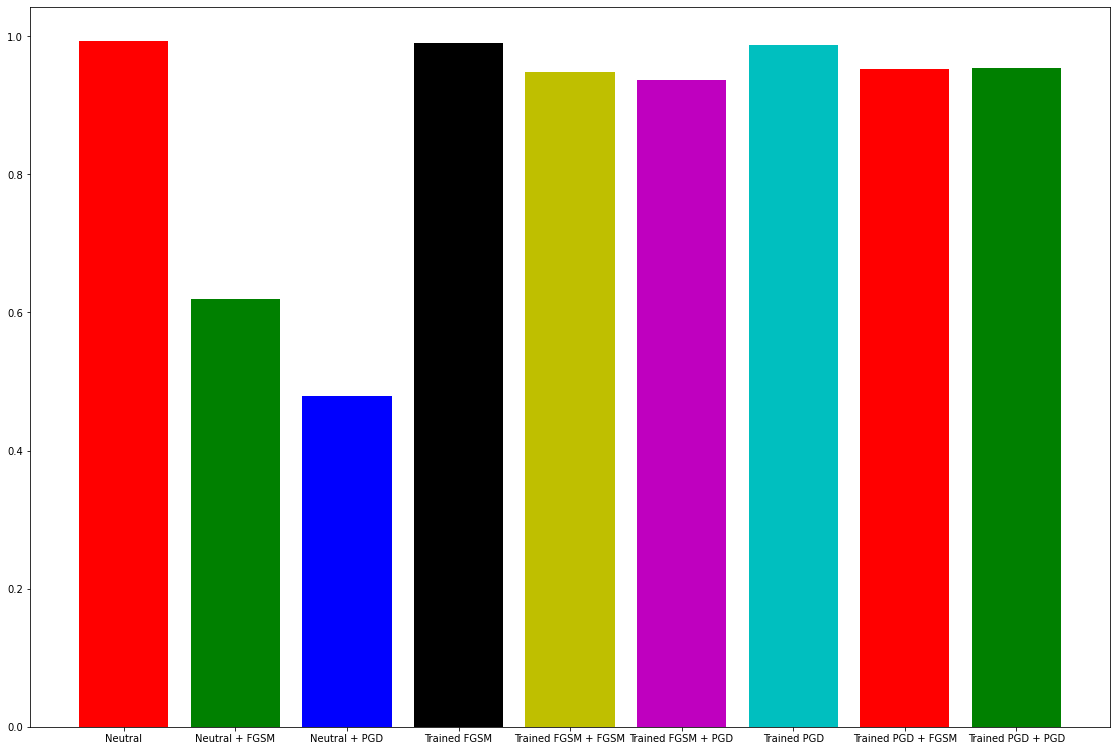

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_axes([0,0,1,1])
models = ['Neutral', 'Neutral + FGSM', 'Neutral + PGD', 'Trained FGSM','Trained FGSM + FGSM','Trained FGSM + PGD','Trained PGD','Trained PGD + FGSM','Trained PGD + PGD']

ax.bar(models,accuracies,color='rgbkymc')
plt.show()

In [ ]:
accuracies_nb2=np.array([0.989,0.050,0.017])
accuracies_nb2


array([0.989, 0.05 , 0.017])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


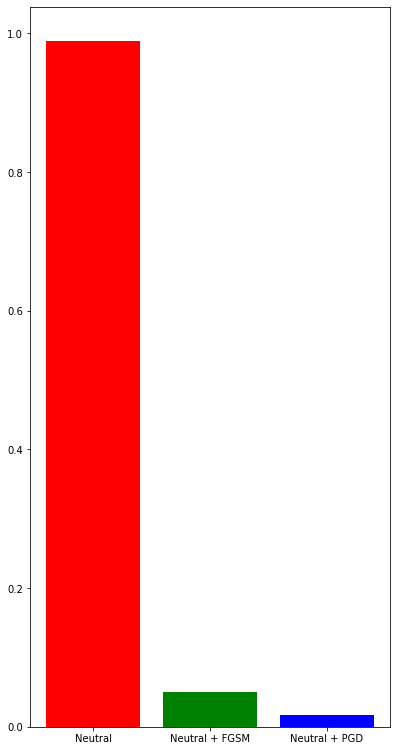

In [ ]:
fig = plt.figure(figsize=(5, 10))

ax = fig.add_axes([0,0,1,1])
models_nb2 = ['Neutral', 'Neutral + FGSM', 'Neutral + PGD']

ax.bar(models_nb2,accuracies_nb2,color='rgbkymc')
plt.show()